This notebook is a tutorial based on the following manuscript in a mix of text and code. 

[INVERSE BOUNDARY VALUE AND OPTIMAL CONTROL PROBLEMS ON
GRAPHS: A NEURAL AND NUMERICAL SYNTHESIS](https://arxiv.org/pdf/2206.02911)

Partial Differential Equations (PDEs) are among the most studied mathematical models, representing many systems in science and engineering. A PDE describes the time evolution of a dynamical system defined over a spatial region.
PDEs and machine learning (ML) can mutually enhance each other. ML can be used to learn solutions to PDEs or to infer PDEs in inverse problems, while PDEs can inspire the design of ML algorithms.

Dynamical systems are ubiquitous in nature and industral applications alike. Here are a short list of possible applications:

- Optimal resource allocation
- Traffic flow and congestion models
- Brain computer interfaces
- Crowd dynamics in urban planning
- Heat transfer in industrial processes
- Water resource management
- Pollution dispersion
- Customer behavior modelling in markeing
- Pricing strategies
- Mean field game theory
- Option pricing

<img src="..\imgs\vonKarman.png" width="500" />

<img src=".\imgs\vonKarman.png" width="500" />
<!-- ![](../imgs/vonKarman.png) -->

A cylinder is obstructing a flow and creating vortices as a result. This type of fluid dynamics can be modelled as a PDE. <a href="https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street">Image source</a>

As an example of the first case, where ML aids in solving PDEs, consider physics-informed neural networks (PINNs), which have gained significant attention in recent years. The idea behind PINNs is to integrate physical knowledge in the form of PDEs into the learning algorithm. The neural network models the solution of the PDE, and with automatic differentiation, the network is tuned to fit the data while adhering to the physical laws. After training, a PINN can generate solutions to a PDE given the initial and boundary conditions, eliminating the need for numerical simulation techniques like the finite element method. 

Our work is similar to PINNs in that we aim to learn the differential equation that generated the observational data. However, our approach differs because <u>we do not assume prior knowledge of the form of the PDE</u>, making it applicable in more general settings.

An example of how PDEs can inspire novel ML algorithms is the diffusion equation, which models information propagation over a topological space. The diffusion equation is a well-known PDE that describes the diffusion of fields such as energy, mass concentration, or information over a medium. It has been shown that the dynamics of graph neural networks (GNNs) can be interpreted as the numerical integration of the diffusion equation over a discretized space. GNNs are neural networks that compute the updated state of nodes in a graph based on their neighboring nodes, with message passing implemented over the edges. The underlying graph of a GNN is analogous to the discretization schemes used in numerical solutions of PDEs. This natural connection between GNNs and PDEs makes GNNs a strong candidate for modeling the updates of dynamical systems described by <u>unknown PDEs</u>.

Our explicit goal is: using graph neural networks to learn a dyanmical system on a graph with boundary. This is done through a model called _Boundary Informed Graph Neural ODE_, or for short, **BigNode**.

Our method learns to represent an unknown PDE that generated the observations over space and time, treating it as a system of ODEs at each point in space. We model the observational data as the numerical integration of a GNN over an underlying graph, which is a discretization of the spatial domain. <u>The main innovation of our approach lies in handling the known boundary conditions of the system</u>. 

Unlike the standard PINN approach which imposes boundary conditions as a penalty term in the loss function, our method addresses them in a structured way, similar to how boundary conditions are handled in numerical PDE solutions. We use the underlying graph with boundary nodes and directly enforce the boundary conditions through boundary-injected message passing layers of the GNN. Finally, the integration and backpropagation of the GNN over time are performed using the framework of Neural ODEs.

<img src="..\imgs\mani_with_bound.png" width="500" />

In [1]:
# Now let's jump into some code
import os
import random
import pickle
import numpy as np
import torch
from bignode_no_ctrl import BIGNODE
from utils_sysid import train, inference, compute_RMSE
from utils_visualization import visualize_state_sysid
from utils import experiment_init
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = "data/linear"

# Load graph data
with open(os.path.join(ROOT_DIR, DATA_DIR, "graph_obj.pickle"), "rb") as handle:
    graph_obj = pickle.load(handle)
num_nodes_int = graph_obj["num_nodes_int"]
num_nodes_bound = graph_obj["num_nodes_bound"]

# Graphs are represented in the following format which is friendly to Torch. 
graph_obj

{'graph_name': 'ErdosRenyiGraph0.2',
 'num_nodes_int': 10,
 'num_nodes_bound': 2,
 'num_nodes_ctrl': None,
 'edge_index_int': tensor([[0, 1, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 6, 6, 7, 8, 9, 9, 1, 7, 0, 5, 2, 4],
         [6, 2, 4, 1, 7, 9, 5, 1, 3, 6, 8, 0, 5, 9, 2, 5, 2, 6, 7, 1, 5, 0, 4, 2]]),
 'edge_index_bound': tensor([[11,  7, 11,  1,  4, 10],
         [ 7, 11,  1, 11, 10,  4]]),
 'edge_index_ctrl': None}

We are interested in a model of the form $\dot{x}(t)=D\big(x(t), t\big)$.

In many scenarios, we don’t know, but have data over time in the form￼
$X=\{x(0), \dots, x(T)\}$.

Our goal is to learn $D$ using data $X$. This motivates a boundary value problem on a graph as follows.

<img src="..\imgs\bvp.png" width="300" />

Recall that we have no knowledge of the operator $D$. Hence, we use a graph neural network approximation $D_{\Theta}$ in its place. 

The following plot is our working graph example for the rest of this notebook. Heat propagates through the system by means of the boundary nodes. While the dynamics itself is simple, the model has zero knowledge about it. 
<!-- ![](../imgs/bignode_img1.png) -->
<img src="..\imgs\bignode_img1.png" width="500" />
<!-- from IPython.display import Image, display
display(Image(filename="/Users/boofebeena/Pictures/Plots/bignode_img1.png")) -->

In [3]:
# Load system data
with open(os.path.join(ROOT_DIR, DATA_DIR, "system_data.pickle"), "rb") as handle:
    system_data = pickle.load(handle)

print(system_data.keys())
print(system_data['system_name']) # We're working with synthetic head diffusion data
print(system_data['timestamps'].shape) # 1001 timestamps
print(system_data['U']) # U denotes control nodes, empty in this example
print(system_data['X_int'].shape) # Observations on graph interior with 10 gray nodes
print(system_data['X_bound'].shape) # Two boundary nodes in cyan

dict_keys(['system_name', 'X_int', 'X_bound', 'U', 'timestamps'])
diffusion
torch.Size([1001])
None
torch.Size([1001, 10, 1])
torch.Size([1001, 2, 1])


The data for this particular experiment comes from a numerical simulation of the standard diffusion formula:

$\dot{\bf{x}} = - \kappa \Delta \bf{x}$

where $\kappa$ is a diffusitivity coefficient, and $\Delta = \mathrm{grad}^*\mathrm{grad} = - \mathrm{div}\, \mathrm{grad}$ is the standard Laplacian. 

In [4]:
SYSTEM_TYPE = "linear"
MESSAGE_DIM = 32
EMBED_DIM = 32
REGULARIZATION = True
EXPERIMENT_NAME = "bignode_reg_linear" if REGULARIZATION else "bignode_linear"
EPOCHS = 1500

random.seed(23)
np.random.seed(23)
torch.manual_seed(23)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(23)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Initializing the model
bignode = BIGNODE(input_dim=1, message_dim=MESSAGE_DIM, embed_dim=EMBED_DIM, bvp_type="dirichlet",
                    num_nodes_int=num_nodes_int, num_nodes_bound=num_nodes_bound, device=device)

# Initializing the experiment
experiment_dirs = experiment_init(experiment_name=EXPERIMENT_NAME, graph_obj=graph_obj, system_data=system_data)

In a nutshell, our model is an integral of the unknown differential operator $D_{\Theta}$. 

<img src="..\imgs\model.png" width="500" />

### Boundary Injected Message Passing

The novelty of this algorithm lies in the fact that it treats the model as an open system that has an internal dynamics which is in exchange with its outside world. Below, is a visualization of our boundary injected message passing where node u is boundary and gray nodes are interior. Plot (b) shows the flow of messages. Plot (c) shows the aggregation step. Plot (d) shows the update process. This is loosely inspired by Teacher Forcing in language models. 


<img src="..\imgs\boundary_mp.png" width="1000" />

In [6]:
# Training
model, losses = train(graph_obj=graph_obj,
                system_data=system_data,
                regularization=REGULARIZATION,
                model=bignode,
                model_dir=experiment_dirs["model_dir"],
                epochs=EPOCHS)

# Training evaluation
X_int_hat = inference(graph_obj, system_data, model)
visualize_state_sysid(system_type=SYSTEM_TYPE,
                        graph_obj=graph_obj,
                        X_bound=system_data["X_bound"],
                        X_int=system_data["X_int"],
                        X_int_hat=X_int_hat,
                        visualization_dir=experiment_dirs["visualization_dir"])

epoch: 0, loss: 542.8229, time: 0.1
--- best model saved at epoch 0 with loss 542.8228759765625 ---
epoch: 1, loss: 690.8785, time: 0.1
epoch: 2, loss: 706.5779, time: 0.1
epoch: 3, loss: 720.6321, time: 0.2
epoch: 4, loss: 461.6384, time: 0.1
epoch: 5, loss: 642.9737, time: 0.1
epoch: 6, loss: 641.6926, time: 0.2
epoch: 7, loss: 757.2186, time: 0.2
epoch: 8, loss: 486.9225, time: 0.1
epoch: 9, loss: 604.7982, time: 0.2
epoch: 50, loss: 271.7513, time: 0.2
--- best model saved at epoch 90 with loss 32.65961837768555 ---
epoch: 100, loss: 18.7561, time: 0.4
--- best model saved at epoch 110 with loss 8.373906135559082 ---
epoch: 150, loss: 4.7655, time: 0.3
epoch: 200, loss: 3.4576, time: 0.4
epoch: 250, loss: 8.5950, time: 0.3
epoch: 300, loss: 3.7594, time: 0.4
epoch: 350, loss: 2.5307, time: 0.3
epoch: 400, loss: 0.9369, time: 0.3
--- best model saved at epoch 400 with loss 0.9368977546691895 ---
epoch: 450, loss: 1.4543, time: 0.3
epoch: 500, loss: 4.0928, time: 0.3
epoch: 550, loss

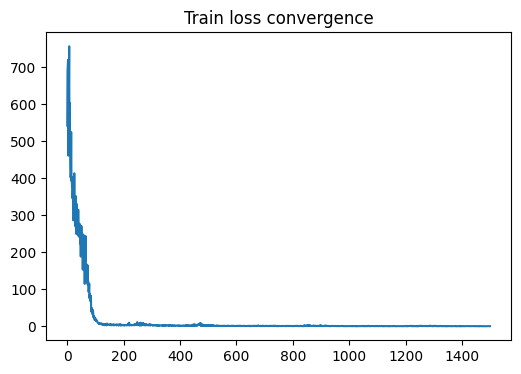

In [7]:
plt.figure(figsize=(6, 4))  # Adjust width and height as needed
plt.title('Train loss convergence')
plt.plot(range(len(losses)), losses)
plt.show()

Note that boundary nodes 10 and 11 bring sinusoidal signals from the outside while the interior nodes start from zero temperature. 

<img src="..\imgs\lin.png" width="1000" />

Below is a quick comparison against some relevant competition. 

<img src="..\imgs\lin_table.png" width="500" />

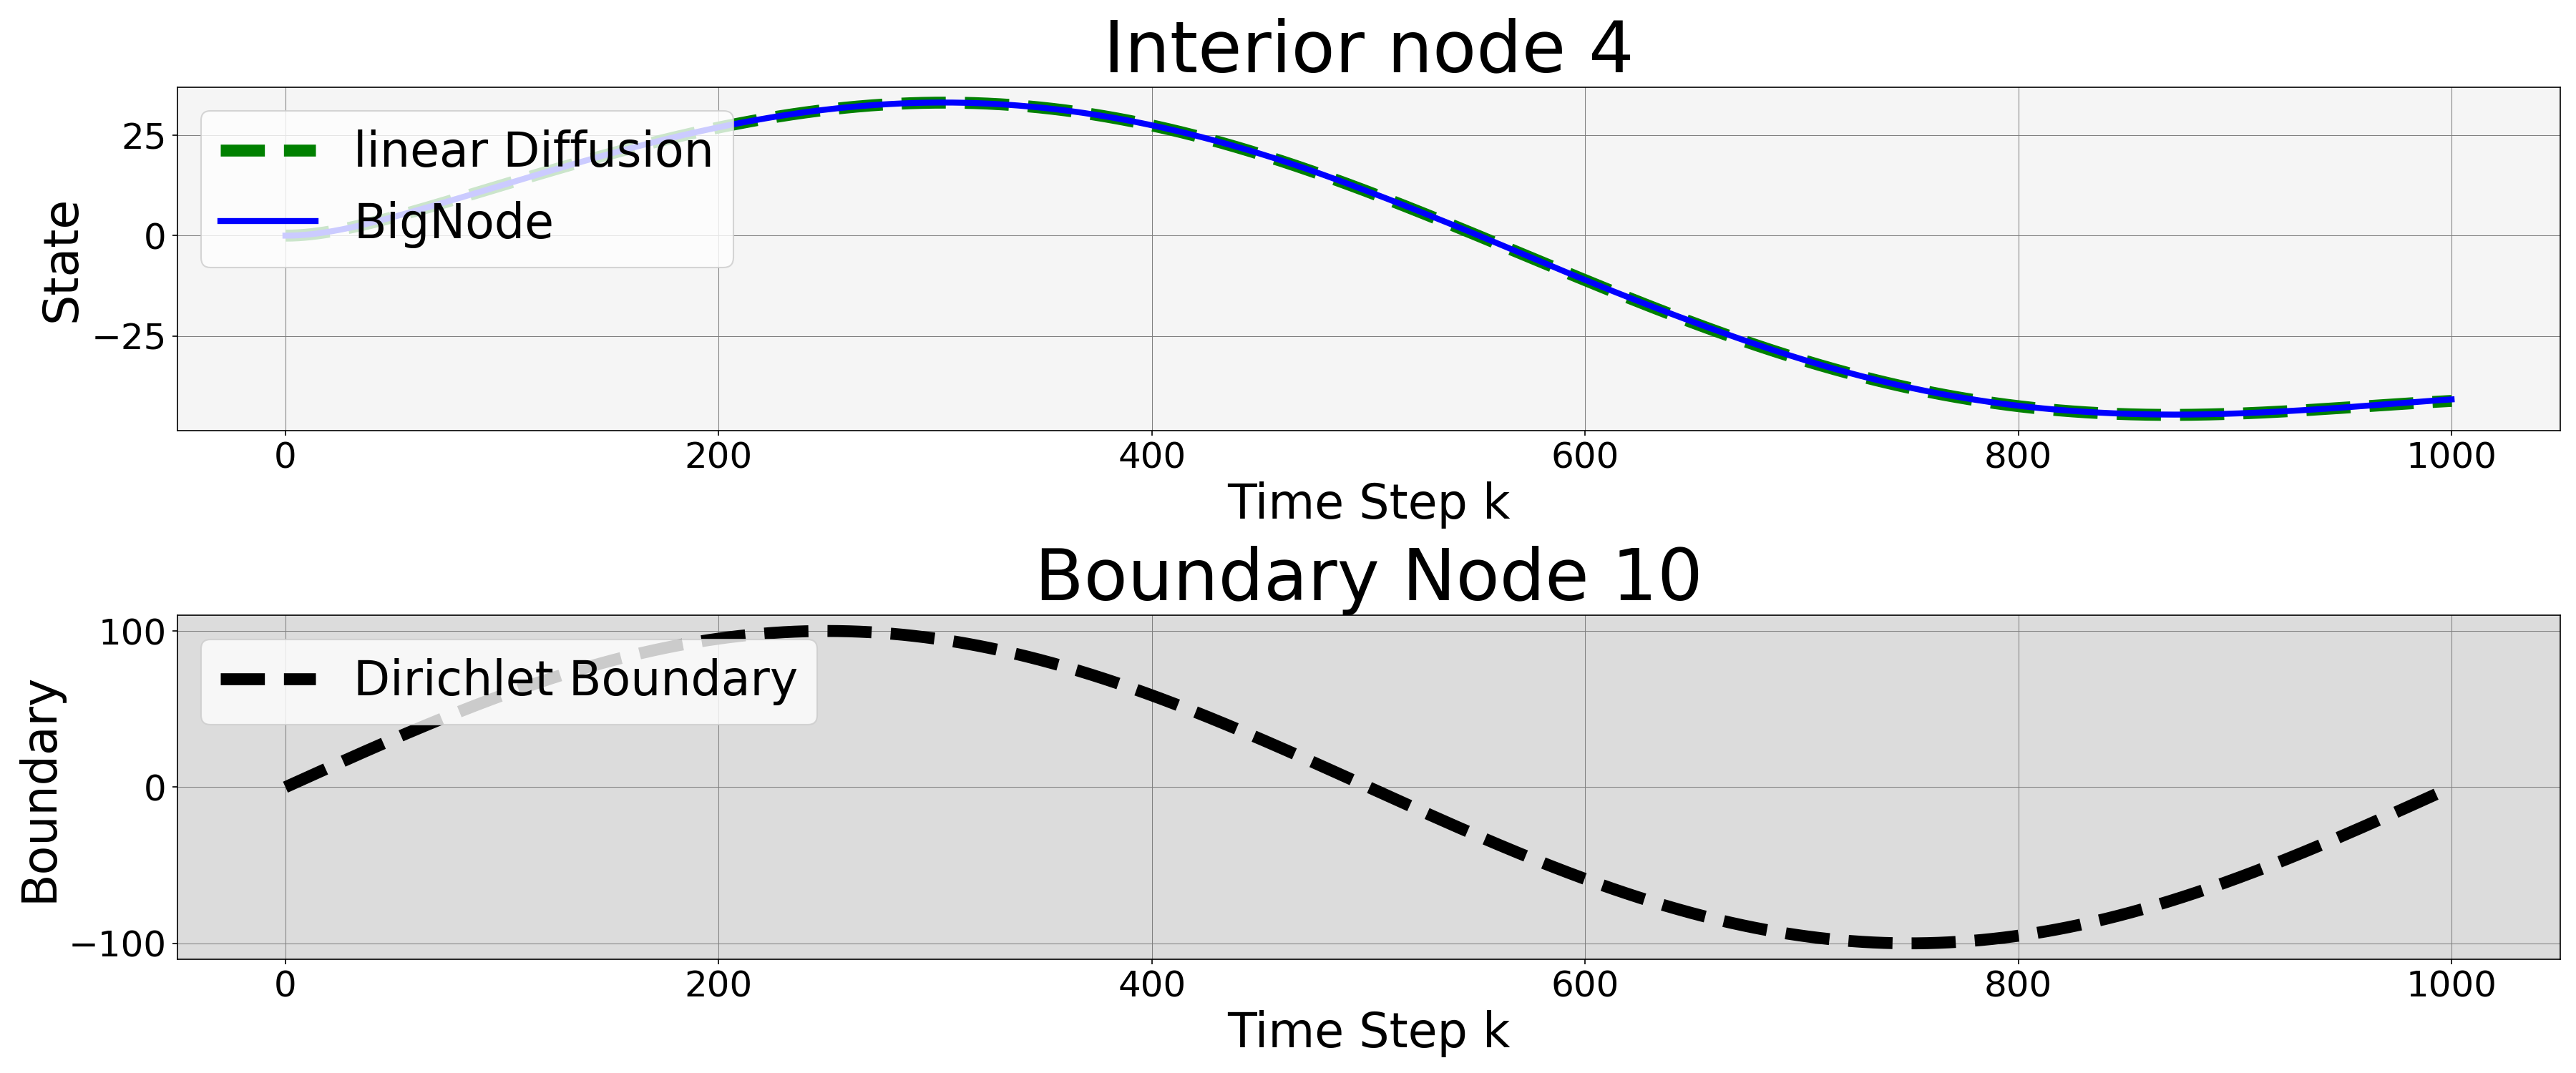

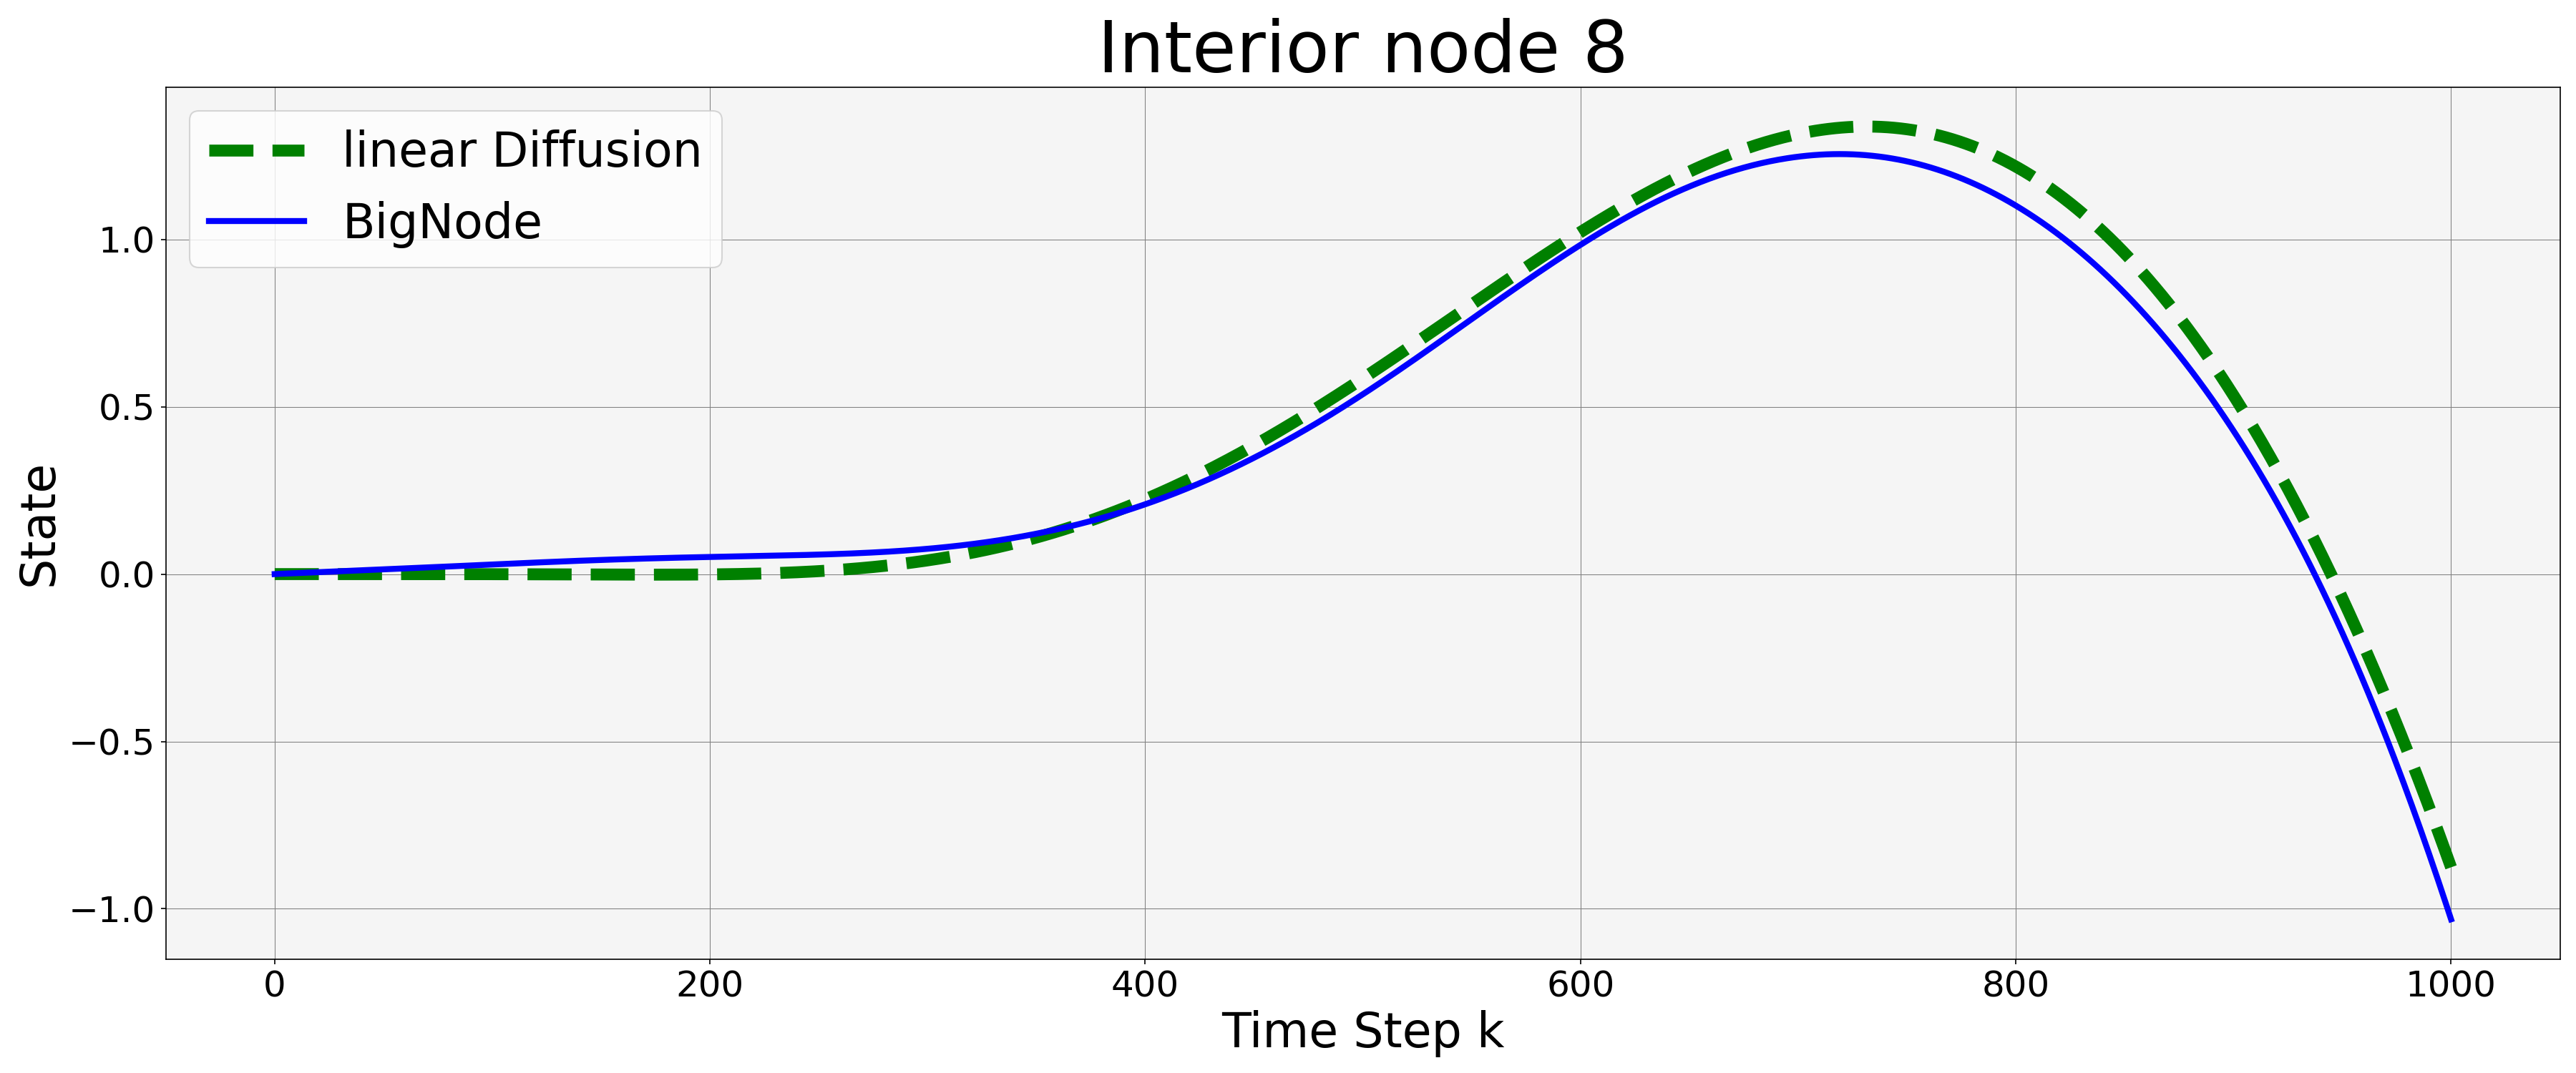

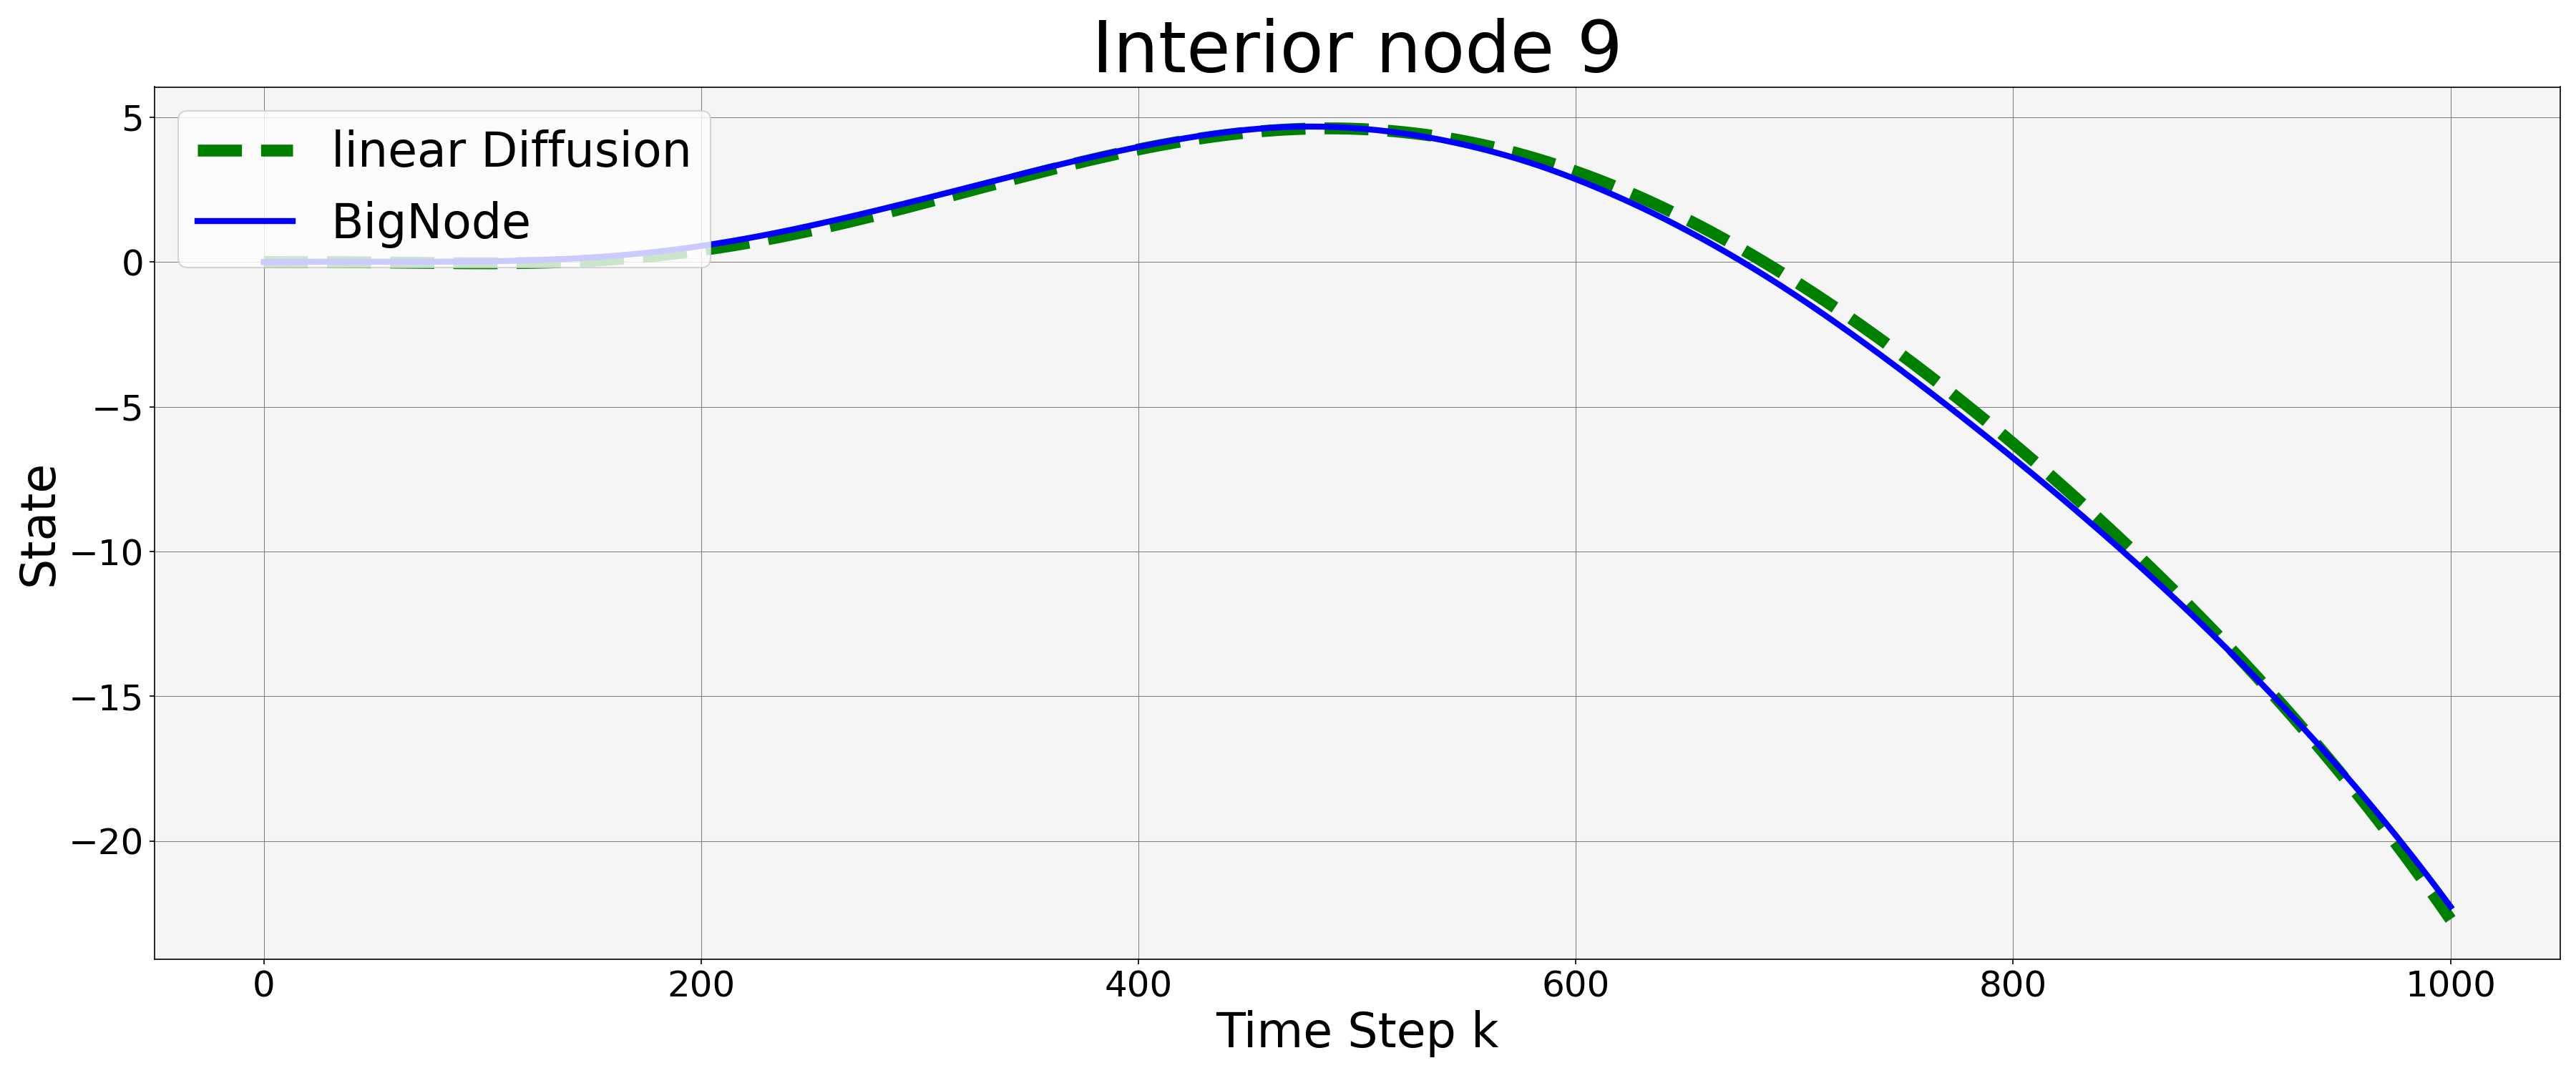

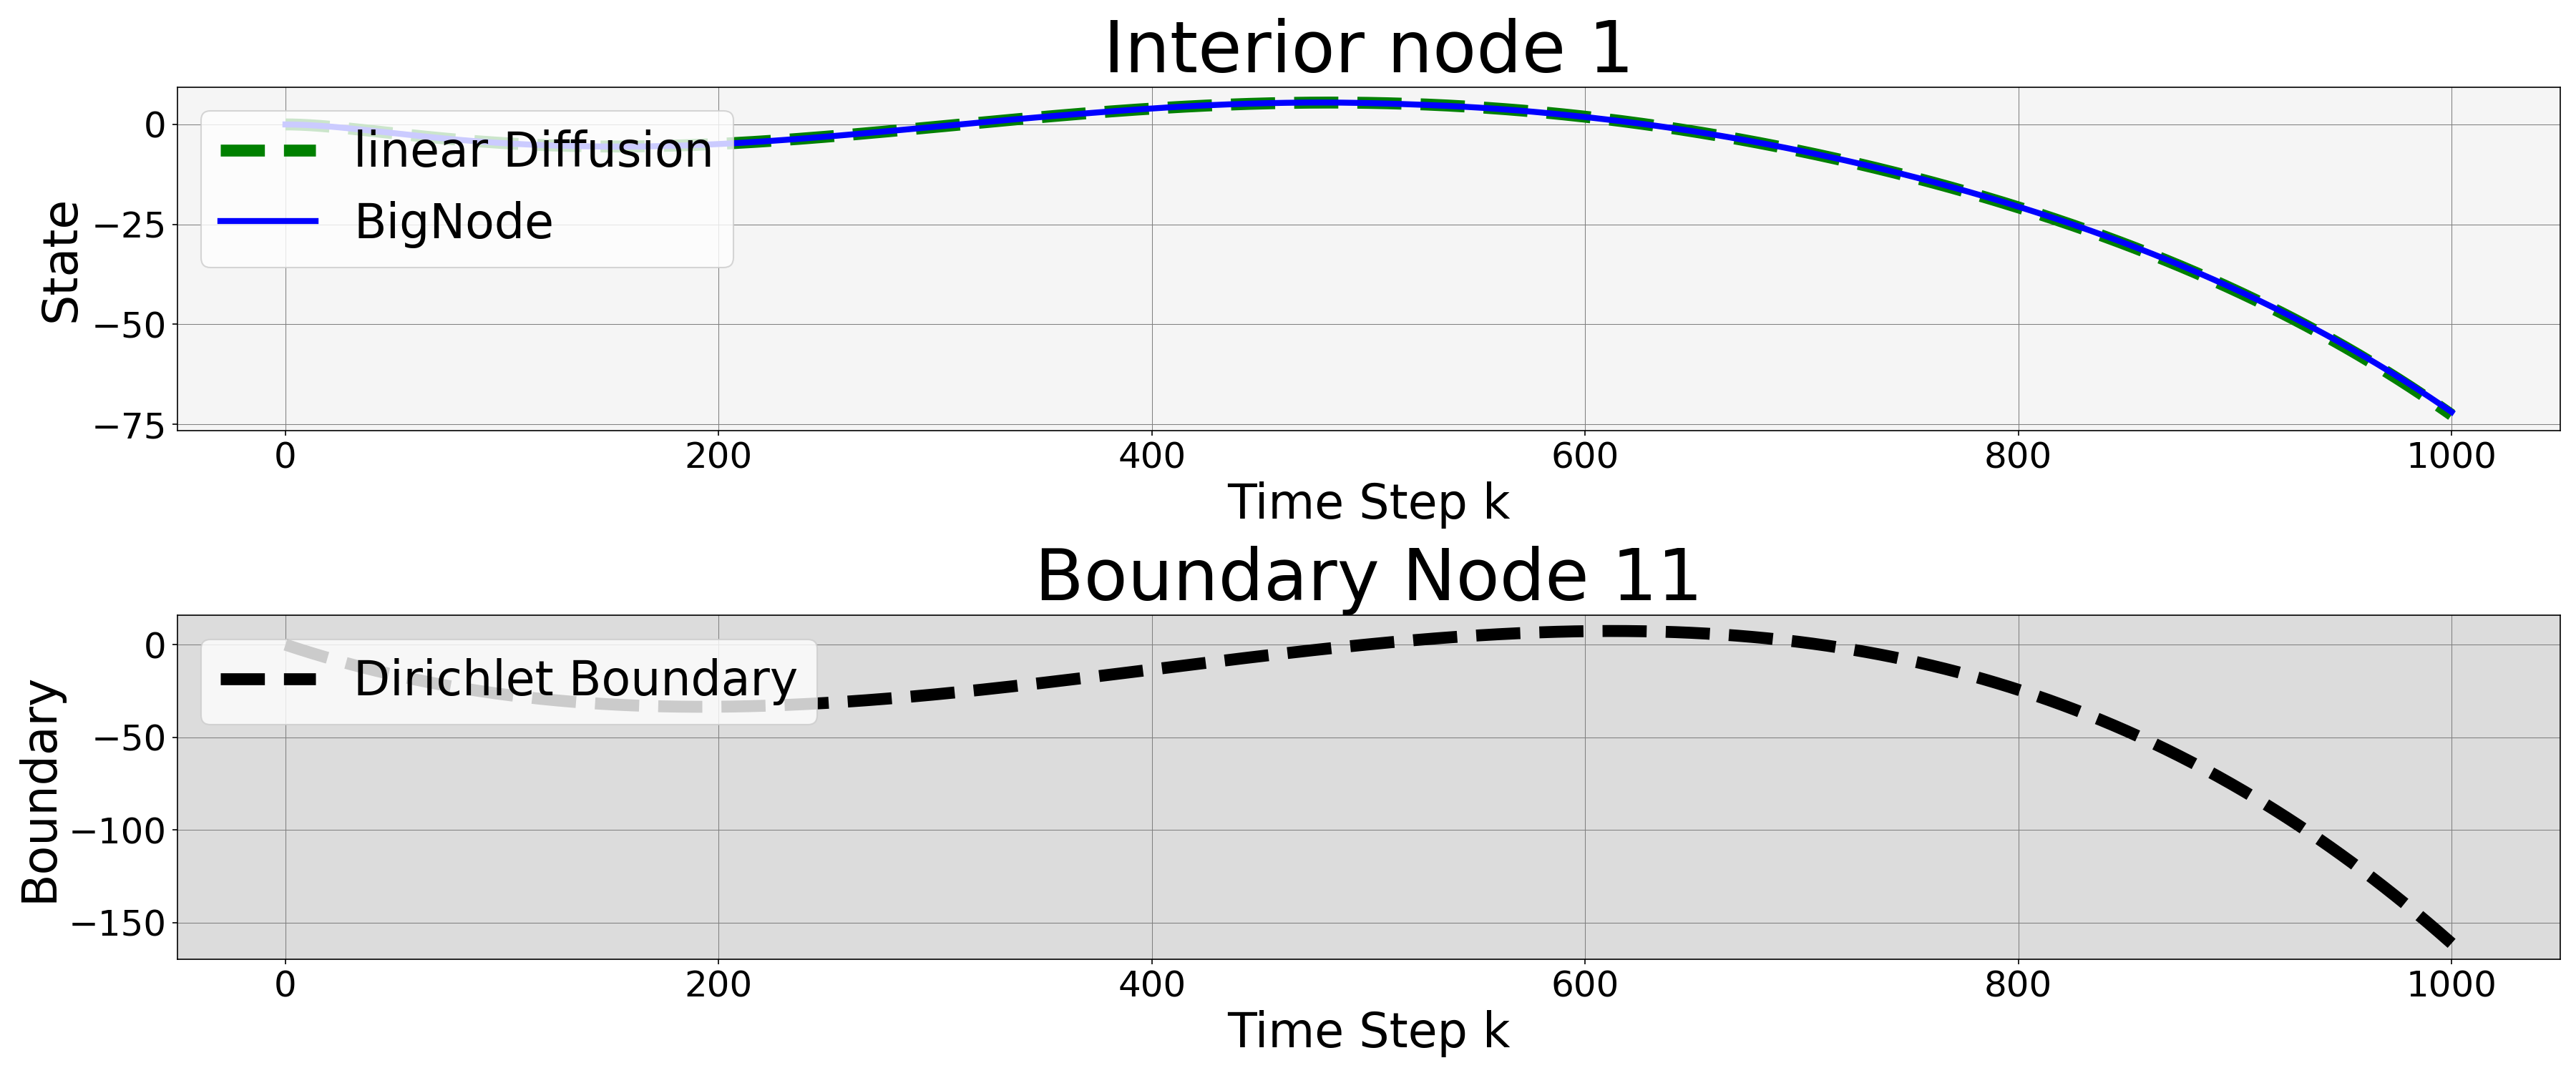

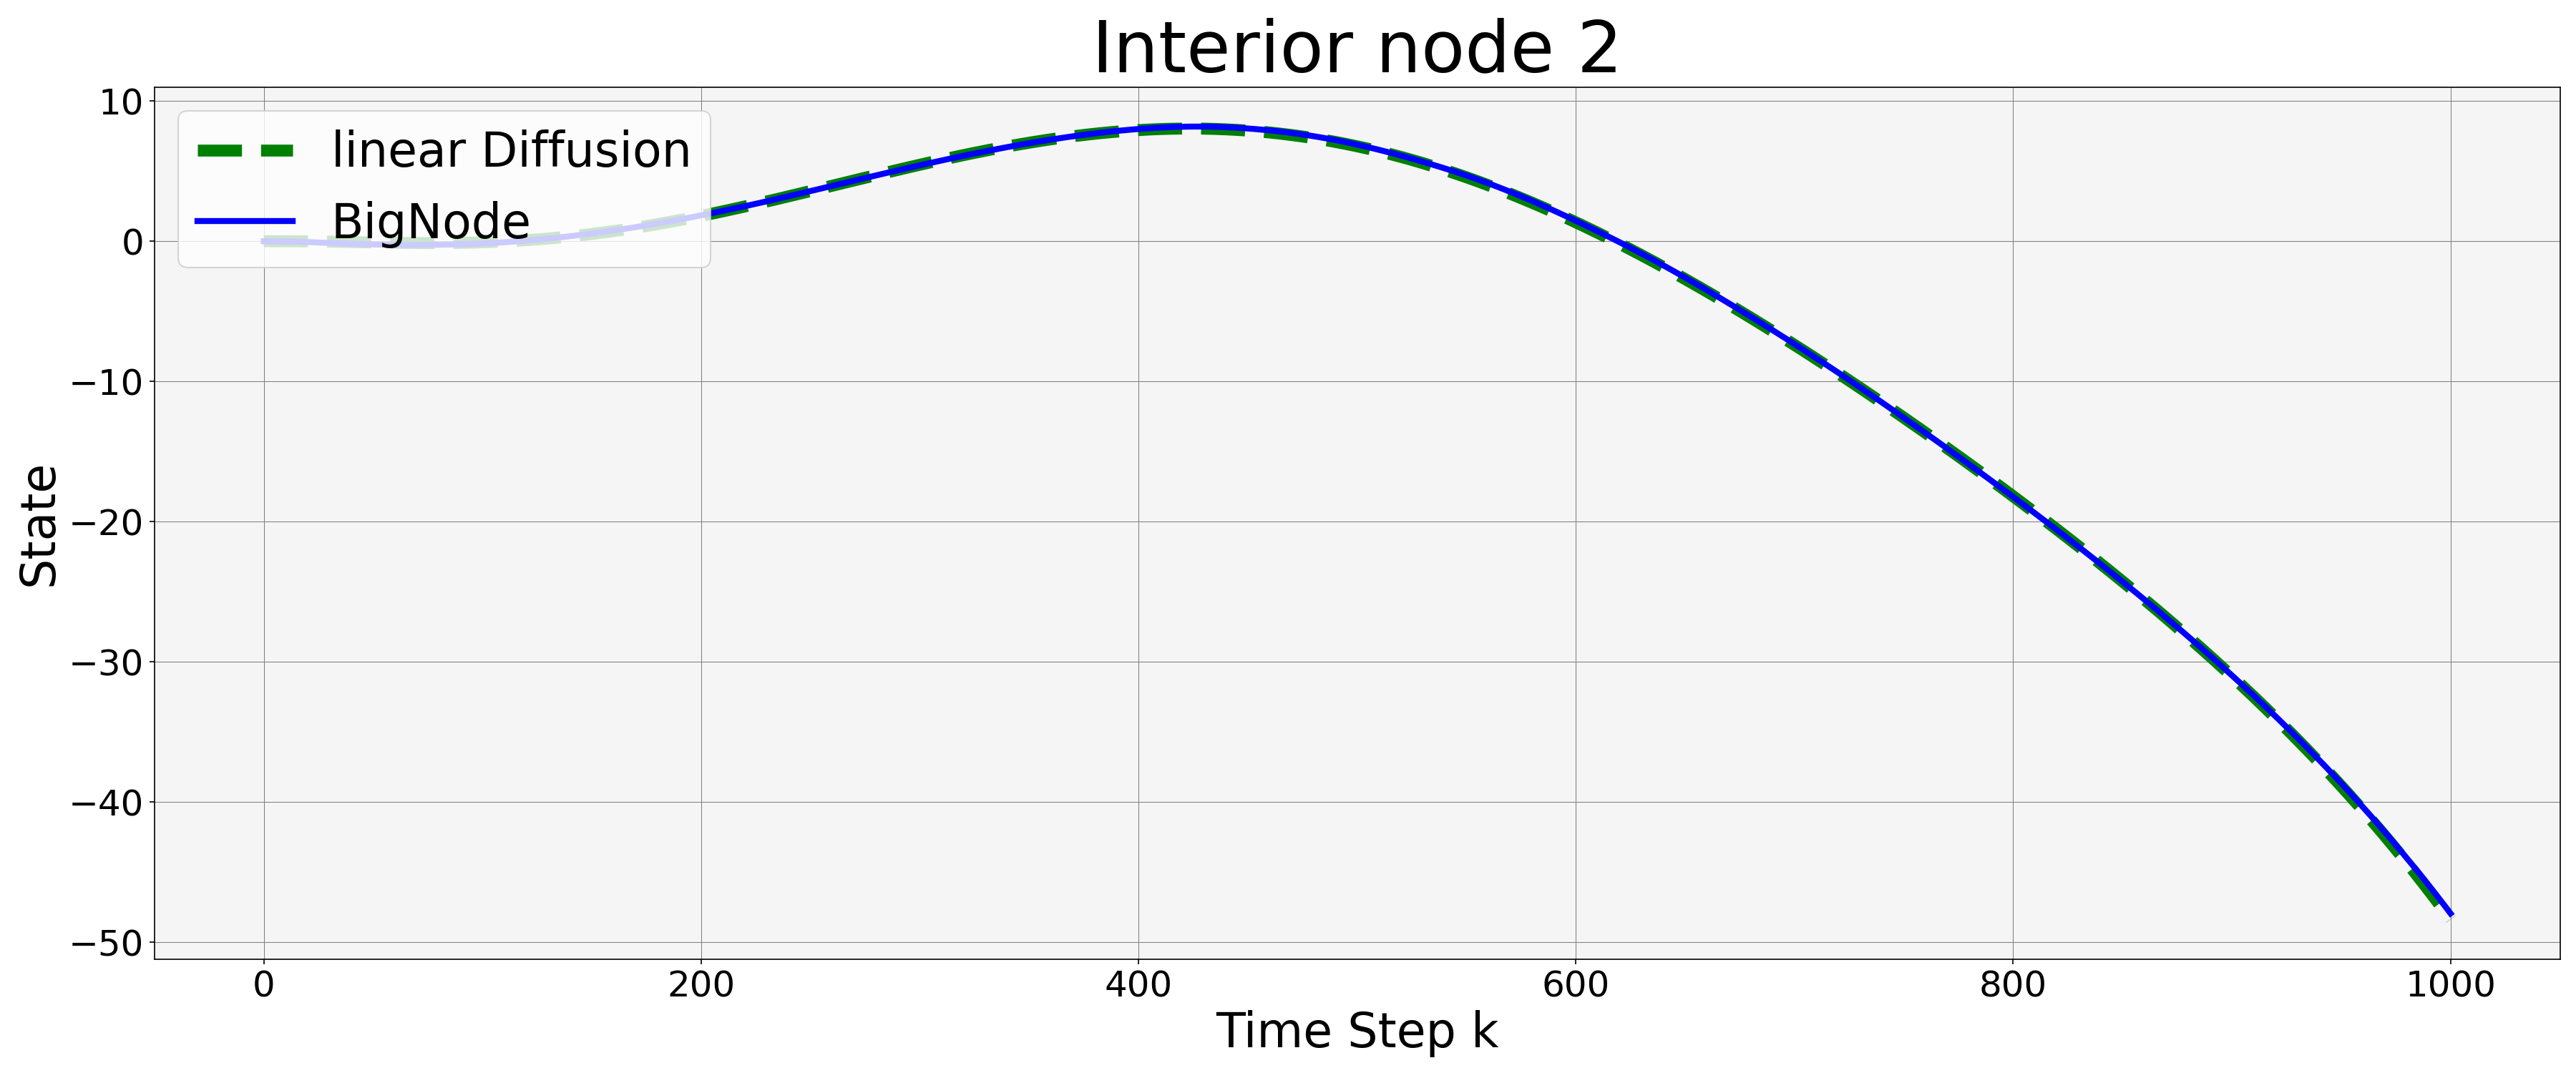

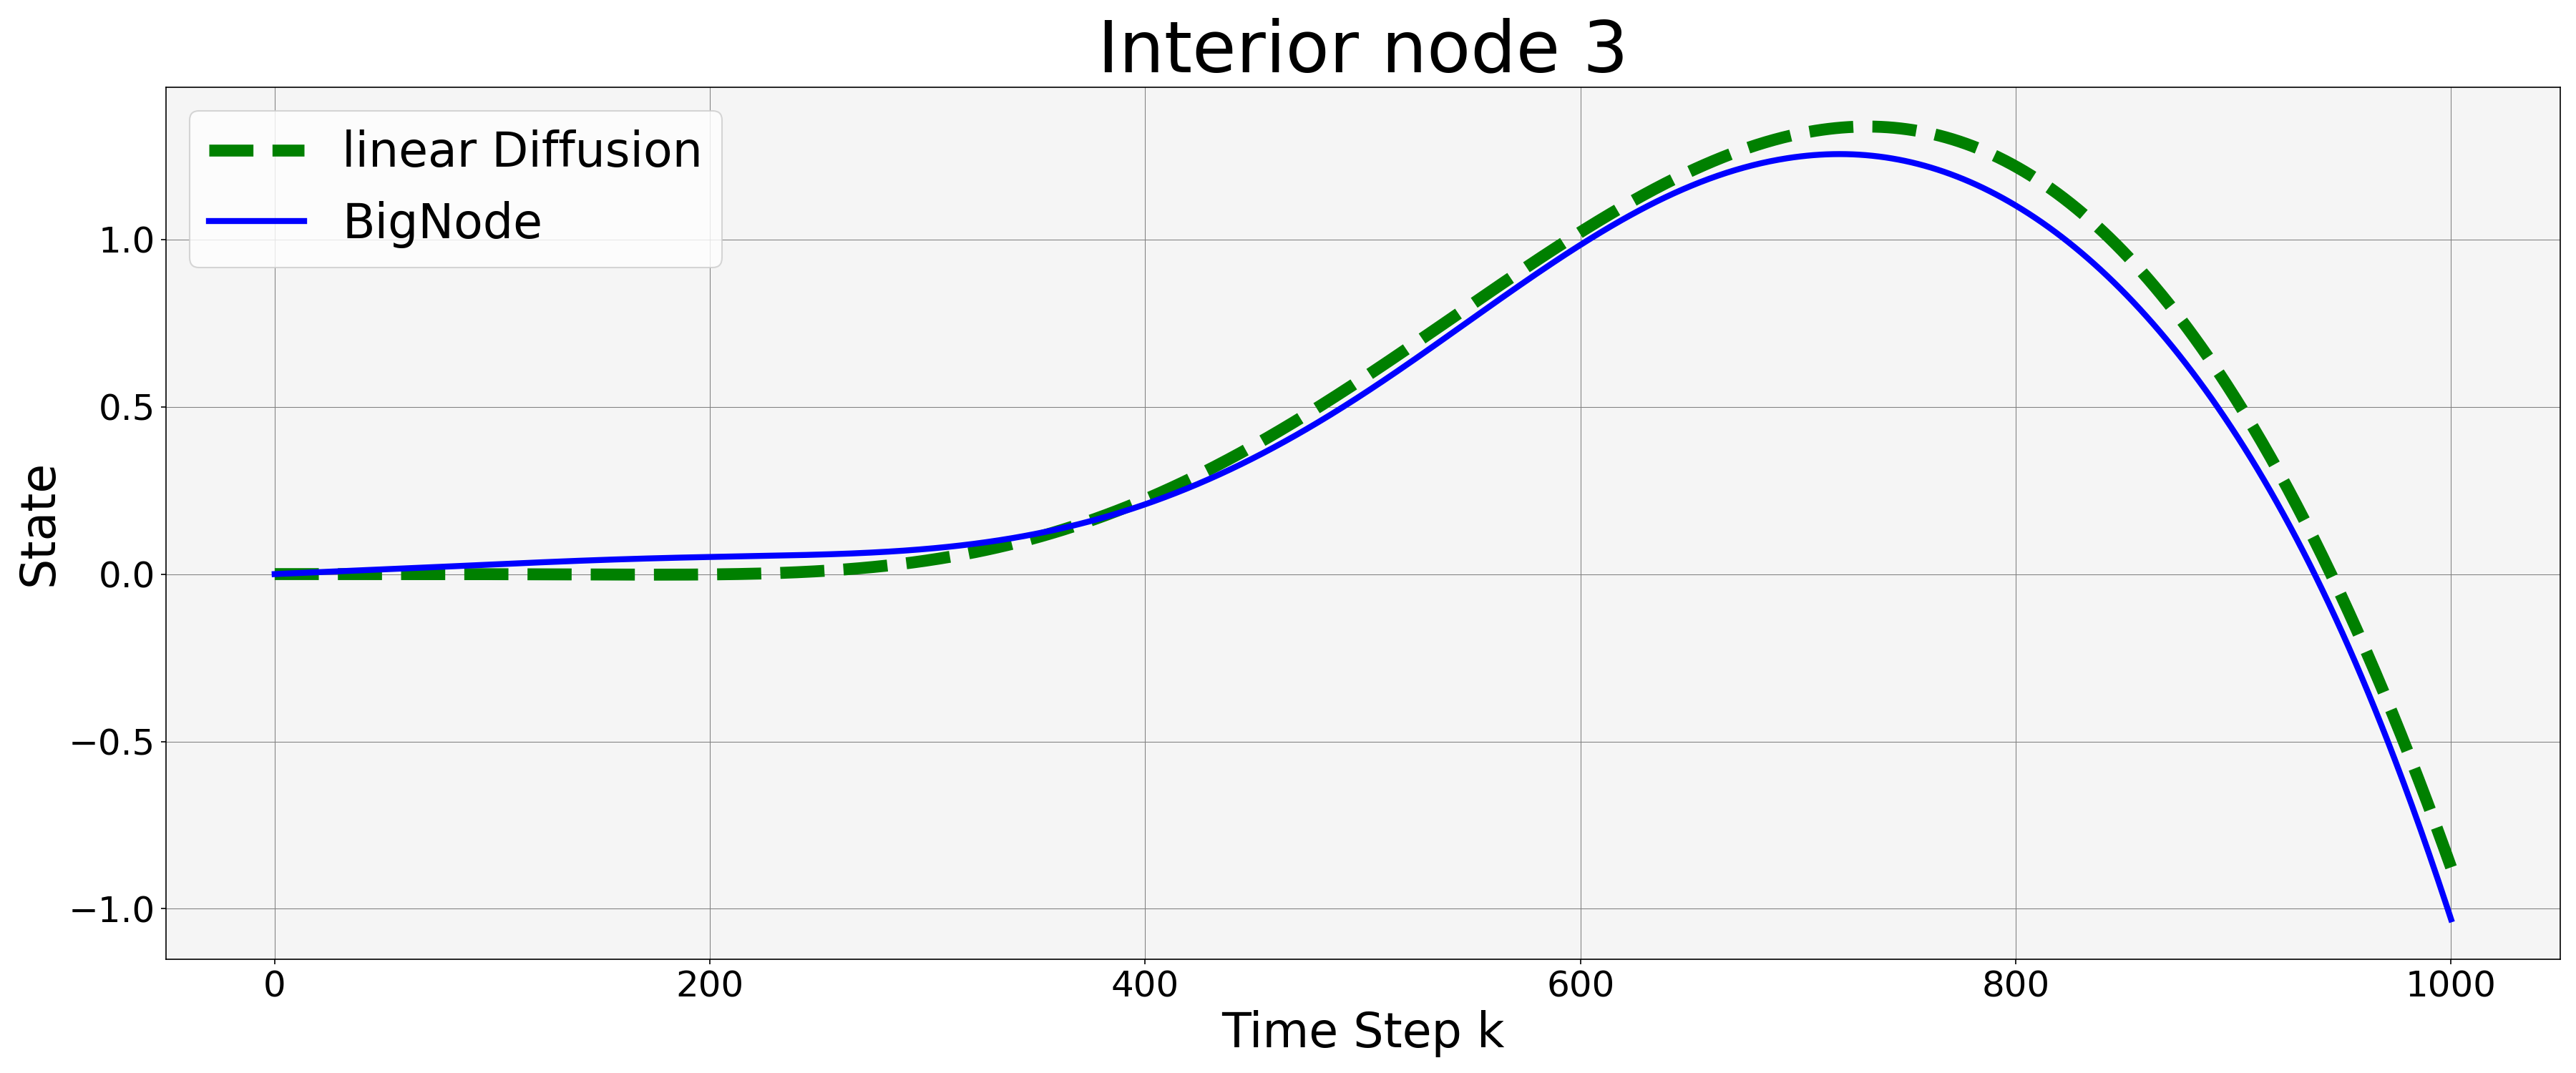

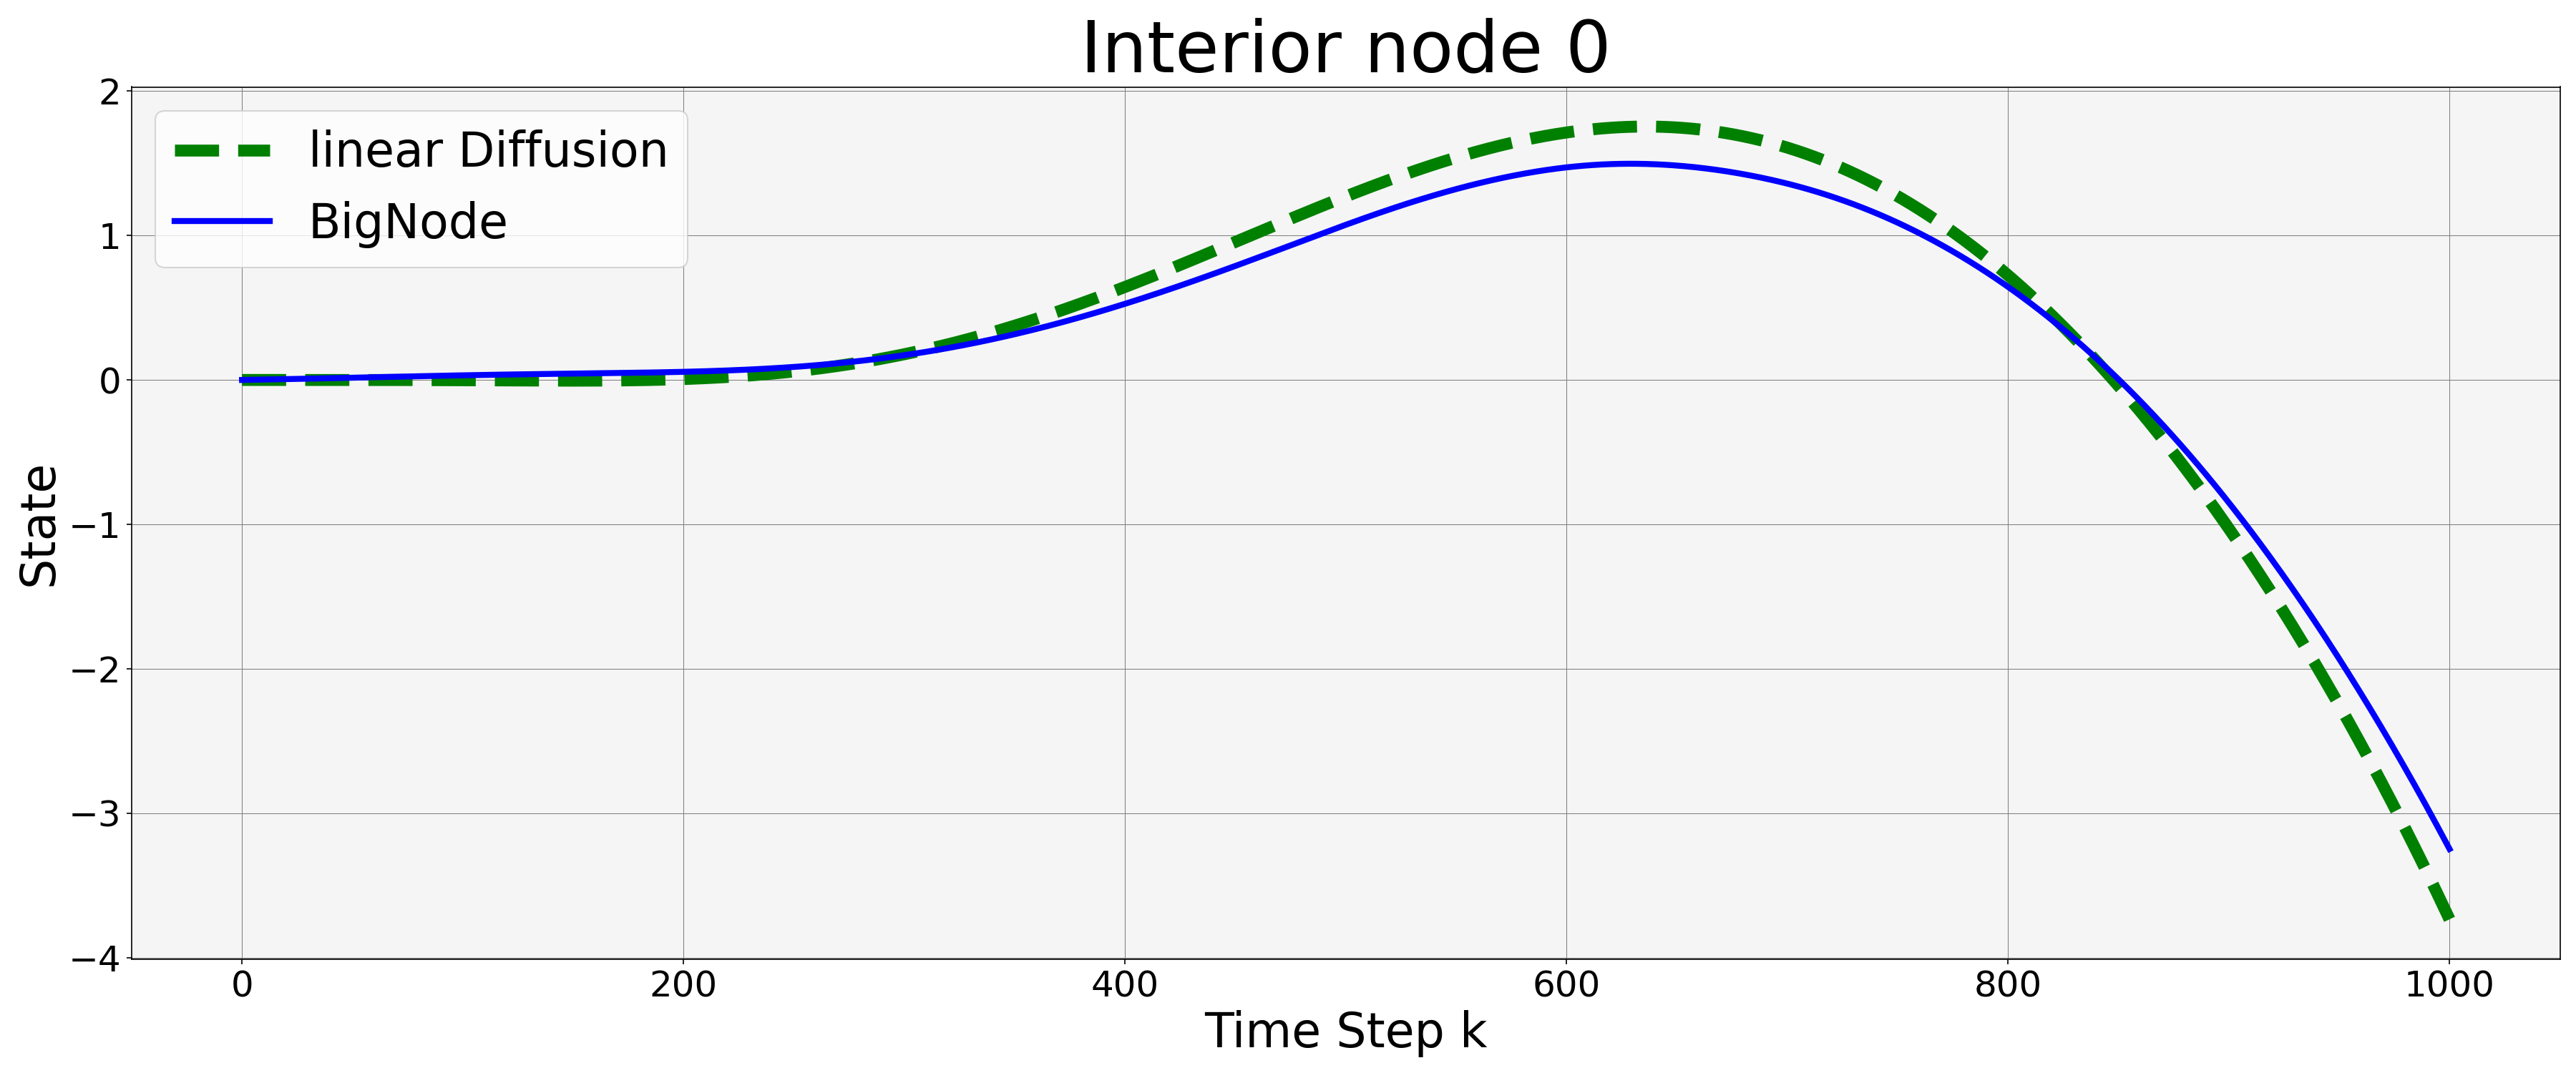

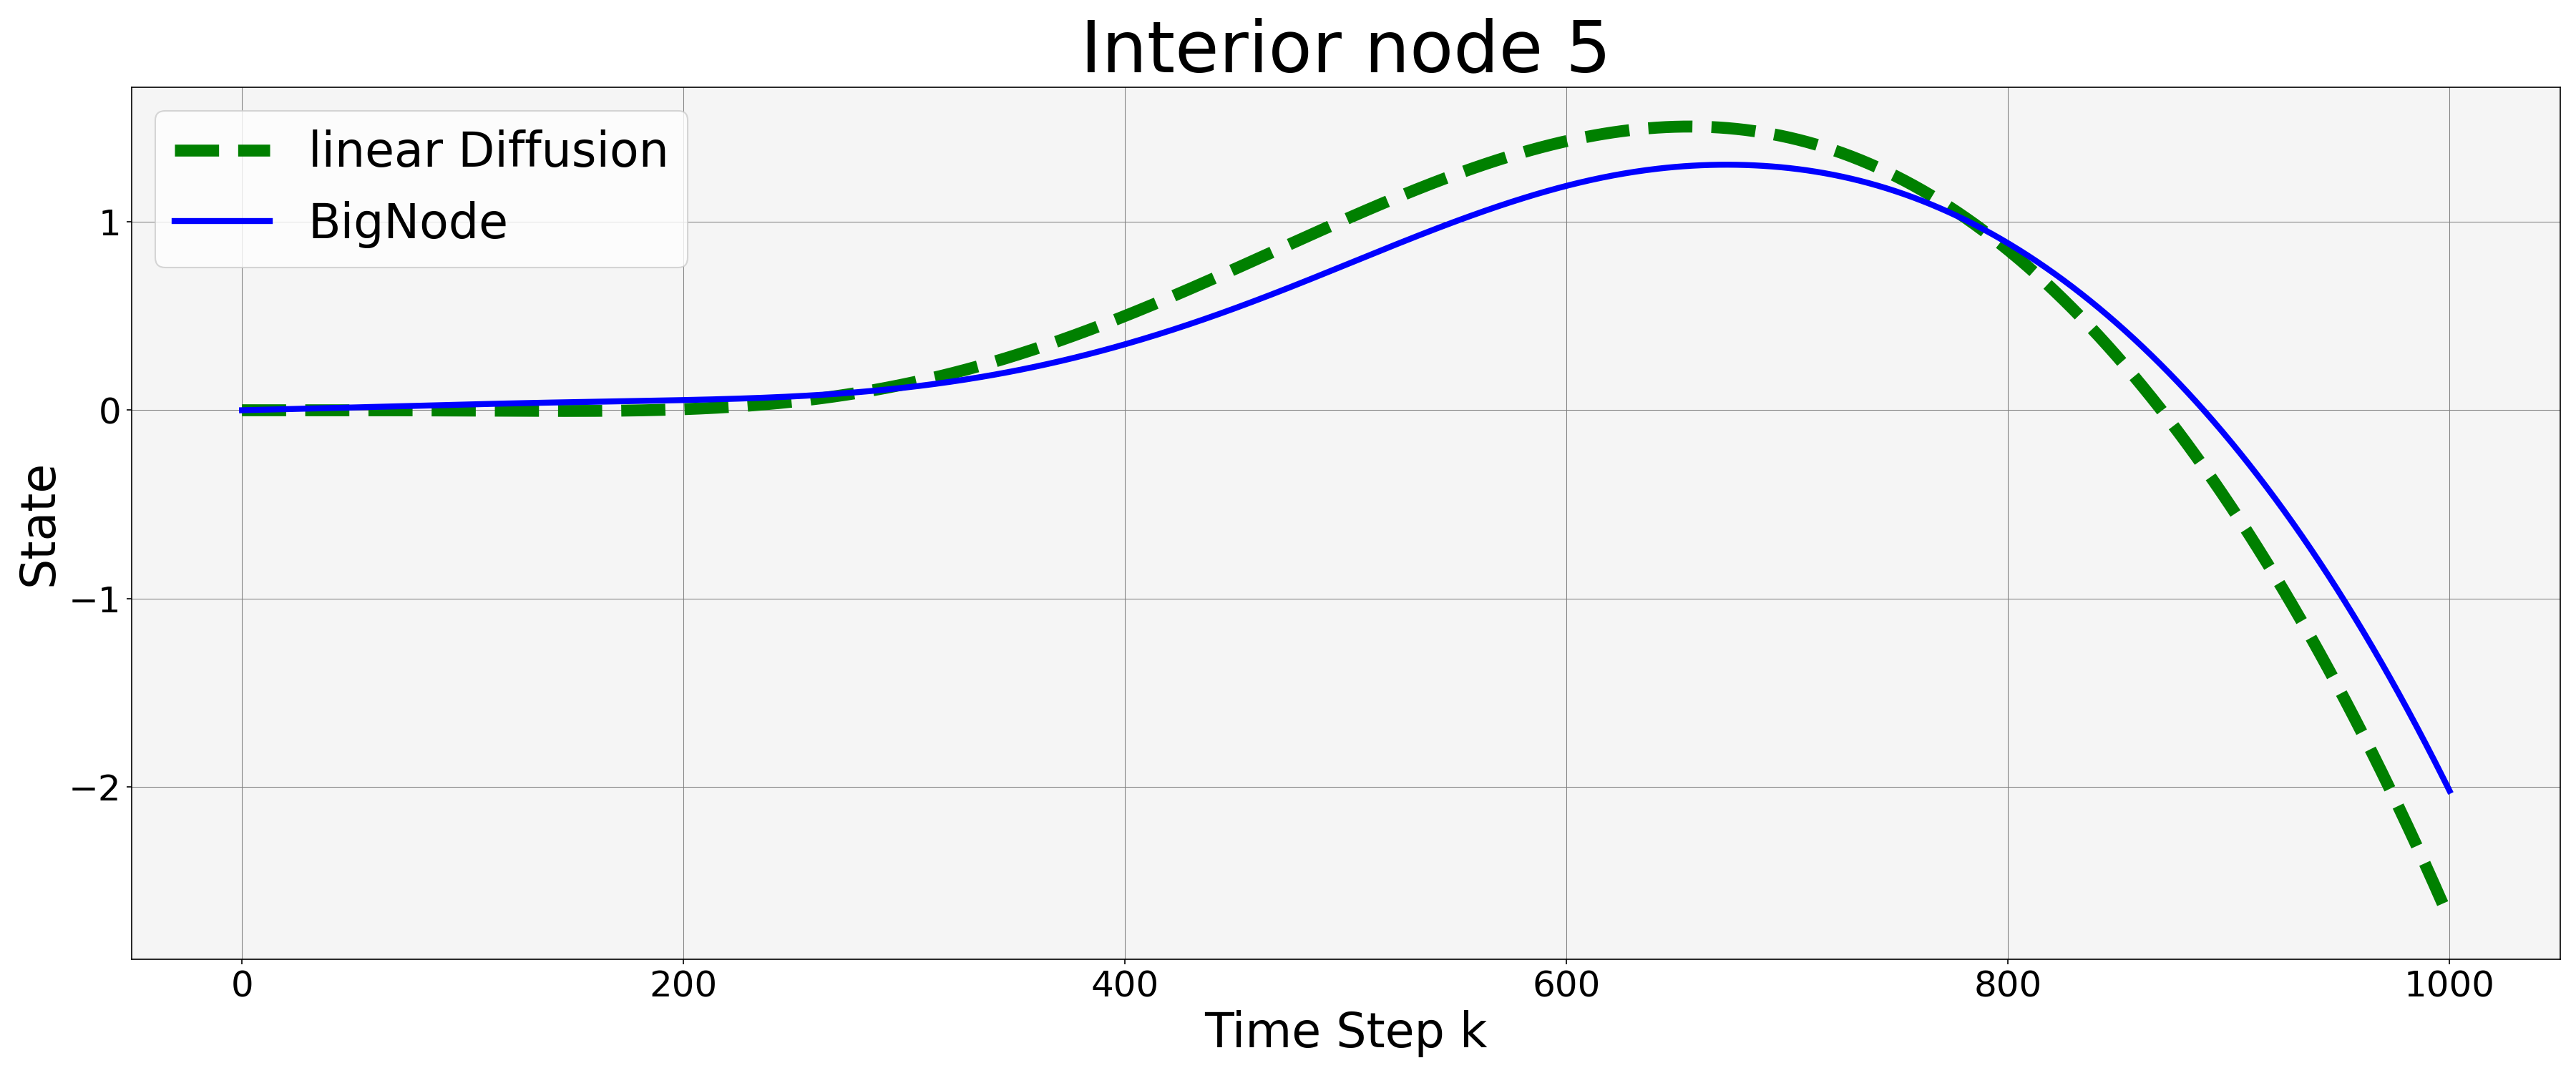

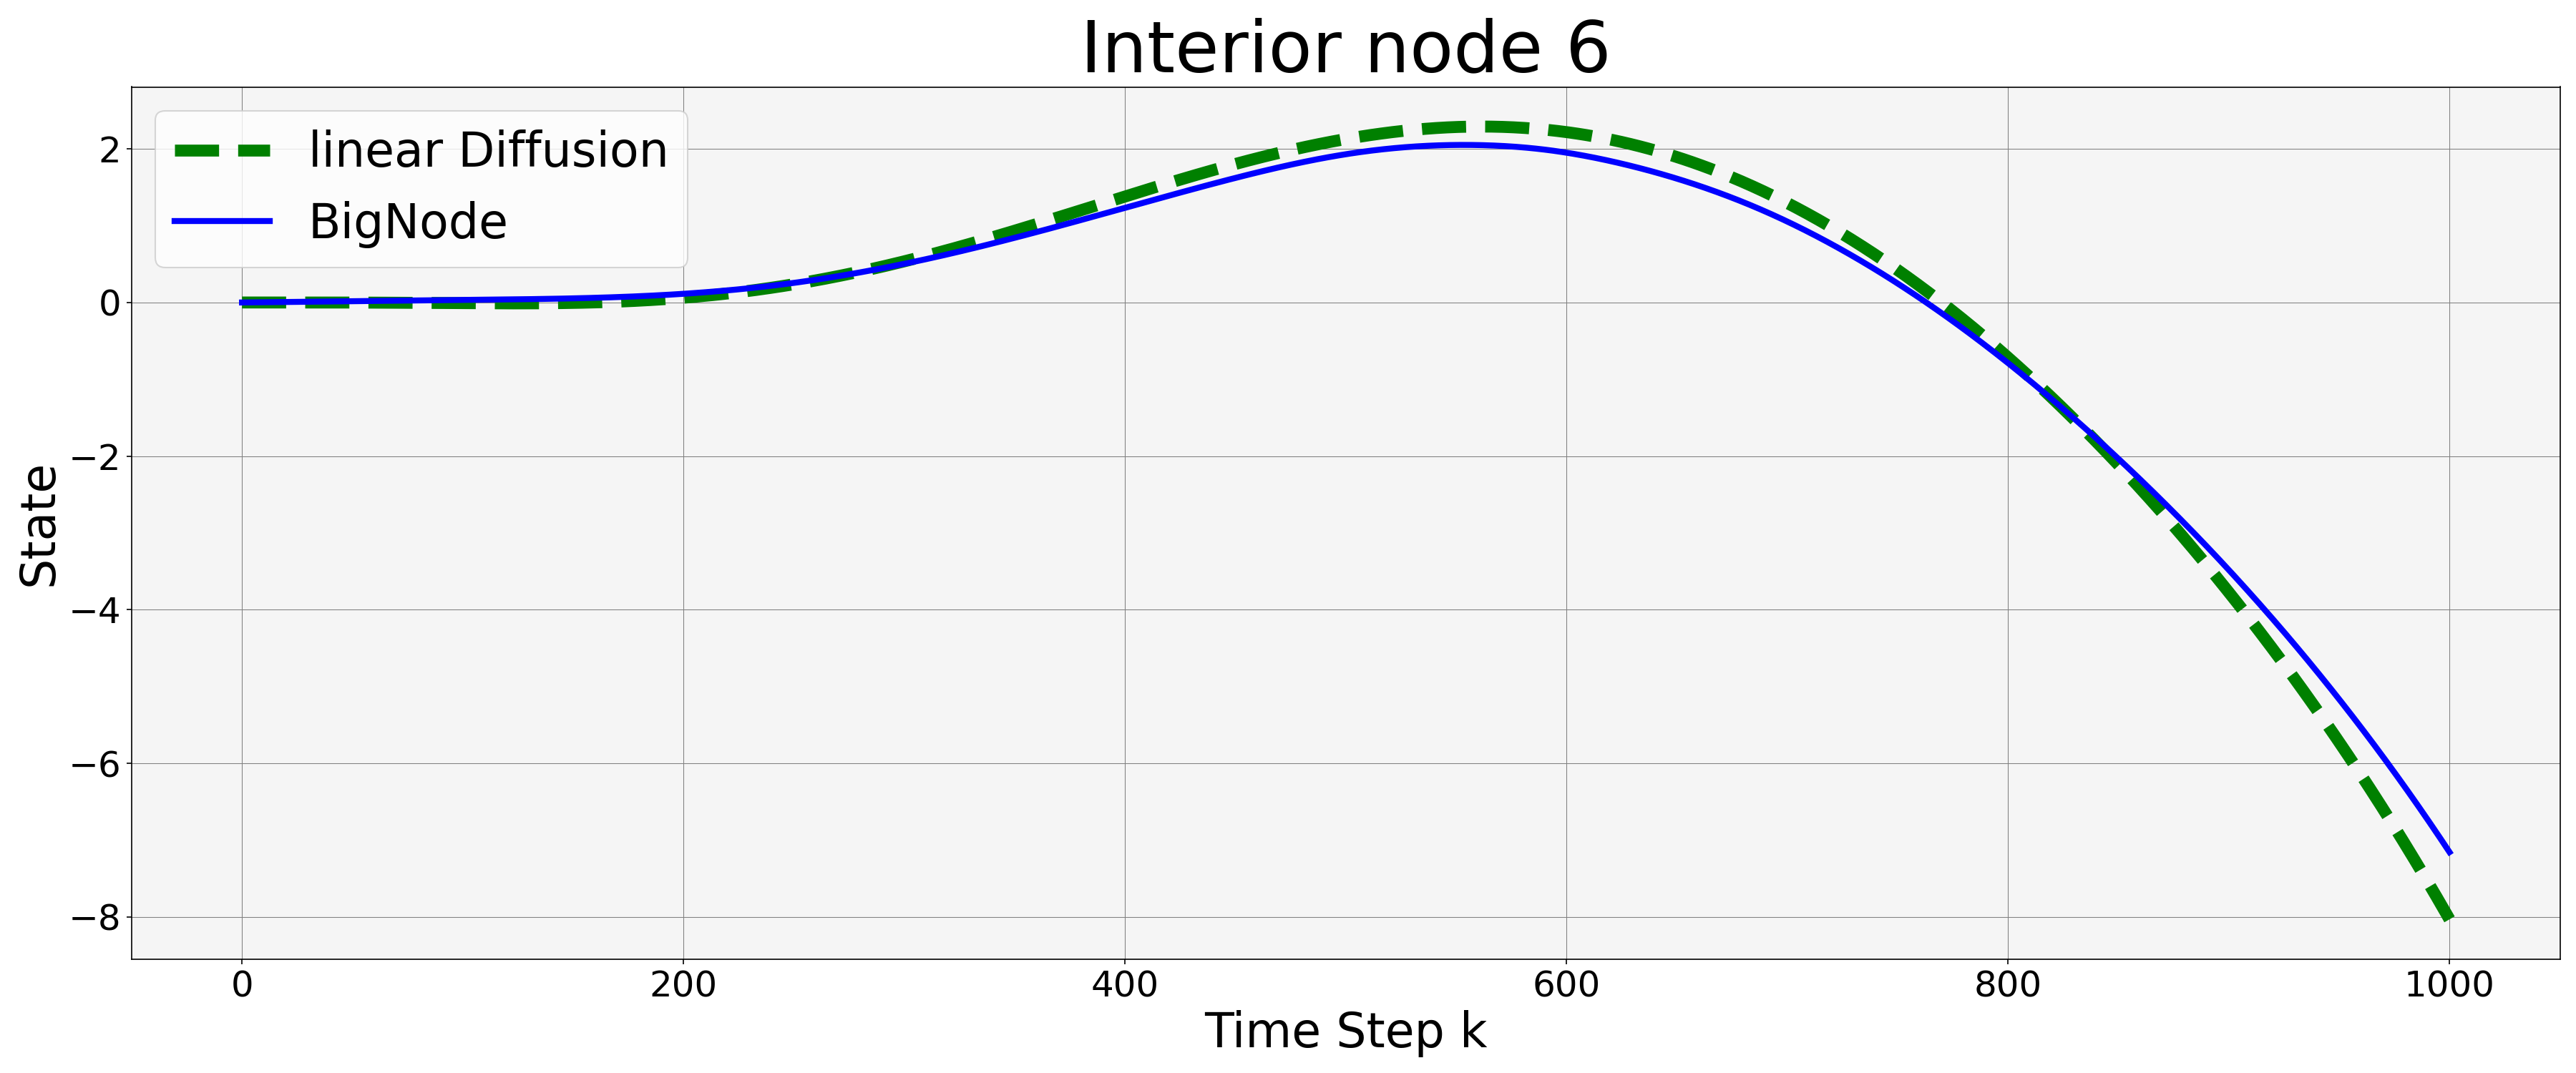

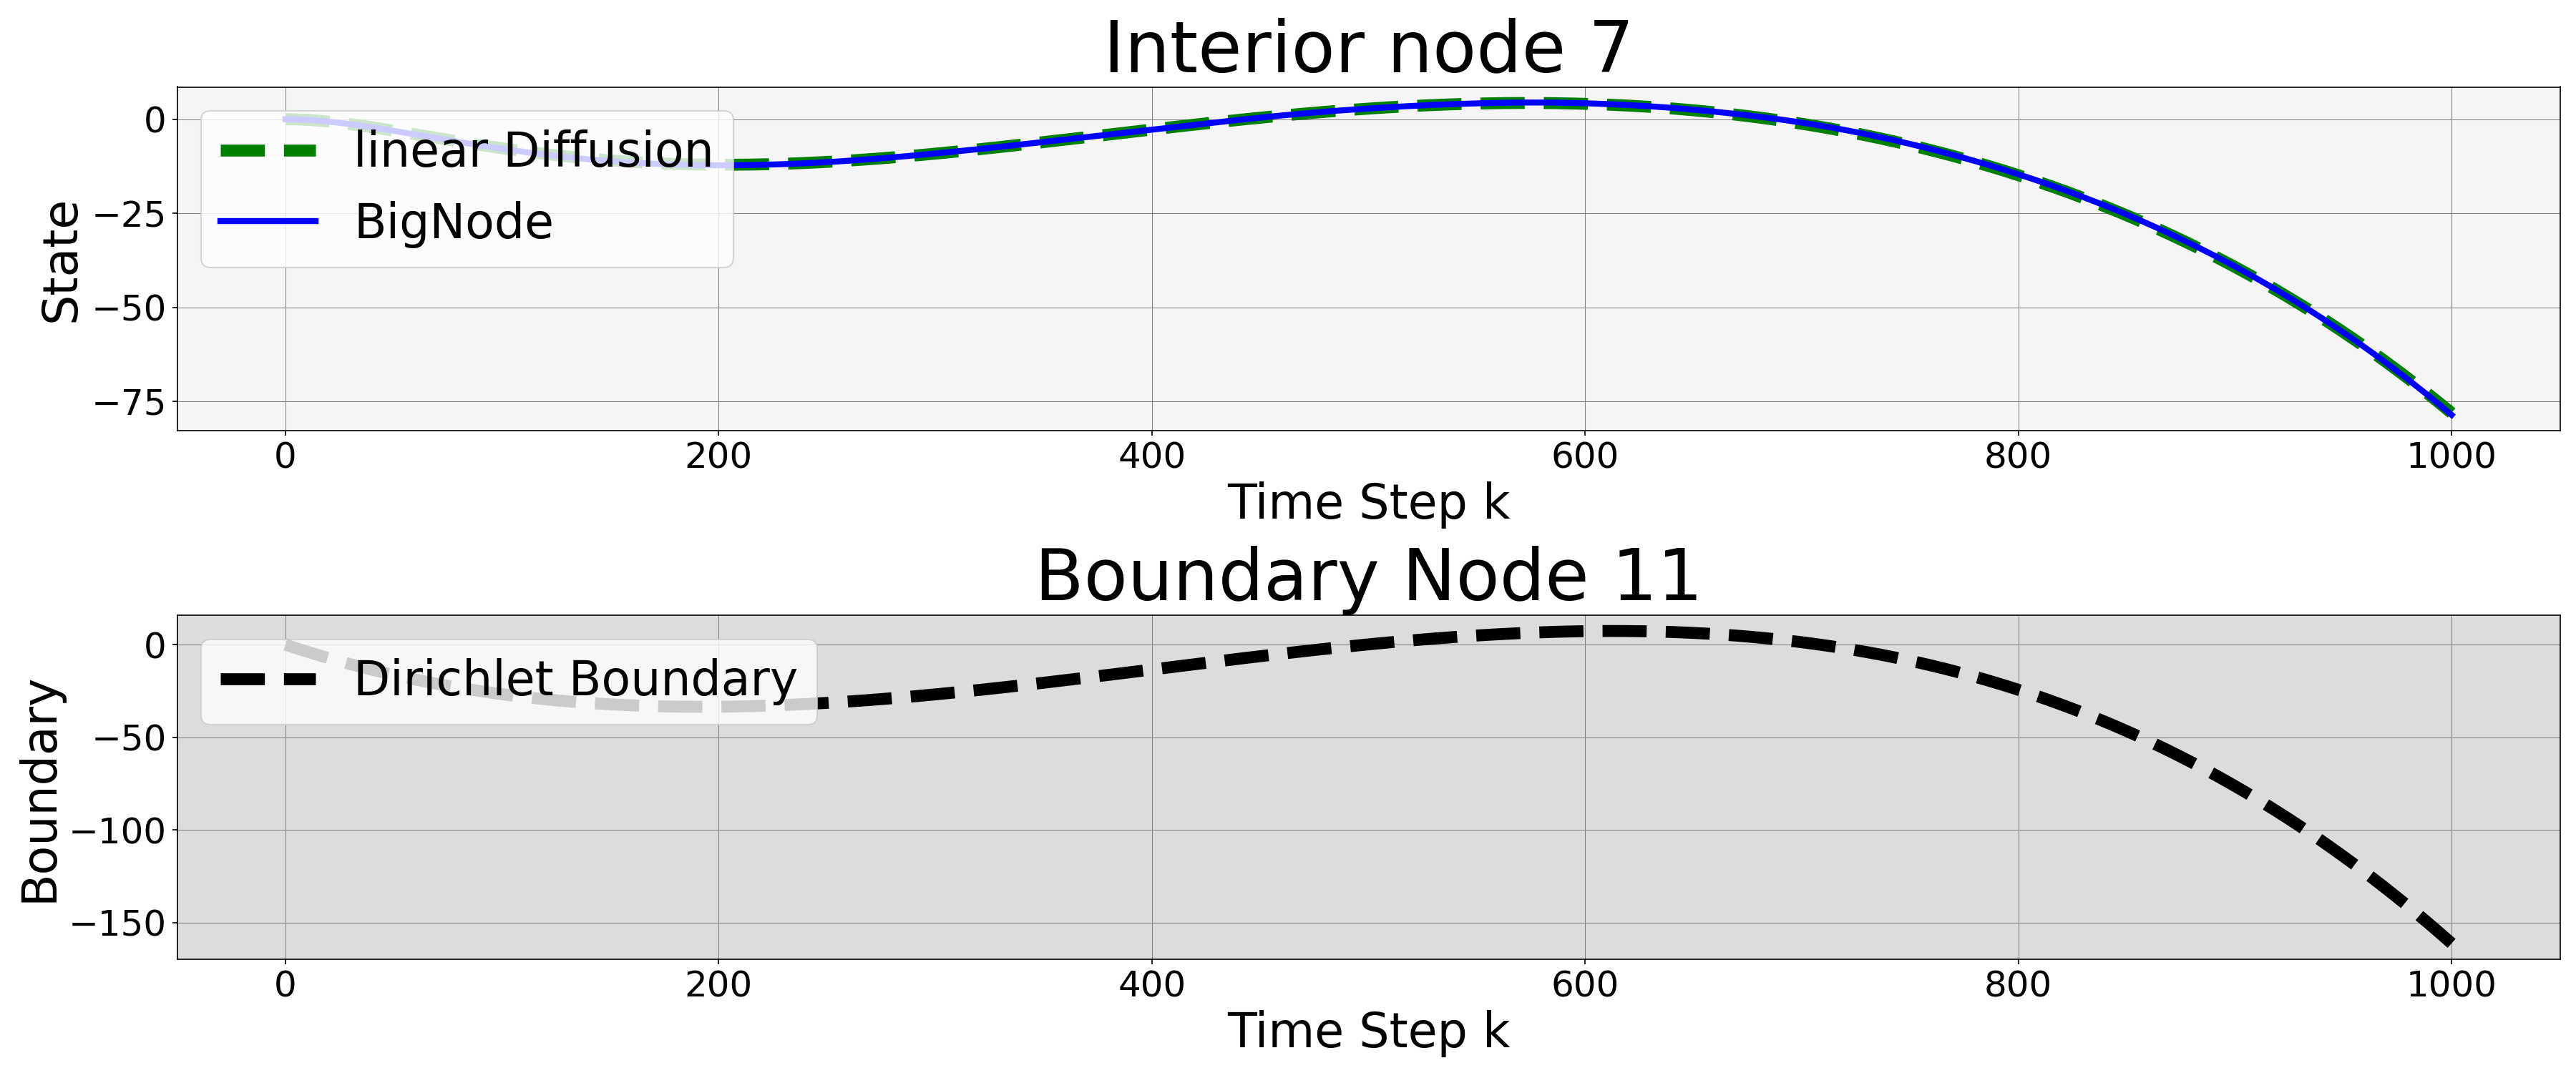

In [8]:
# Inspecting plots individually
art_plots_dir = os.path.join(ROOT_DIR, 'artifacts/bignode_reg_linear_2024-11-09-16-06-24/visualization/')
node_plots = os.listdir(art_plots_dir)

for filename in node_plots:
    display(Image(filename=os.path.join(art_plots_dir, filename), width=450))

Many intresting problems and ideas arise at this point. For instance, a BigNode model trained in this fashion has the ability to fine tune to similar tasks with small amount of training. Other useful topics include working with nonlinear dynamics, regularization and optimal control which we're going to discuss in a subsequent post. 

Credit: Mehdi Garrousian and Amirhossein Nouranizadeh

Any questions/comments welcome.